# Homework exercise 3
## Deadline: upload to Moodle by 7 June 18:00 h

__Please submit your homework either as a Jupyter Notebook or using .py files.__

If you use .py files, please also include a PDF containing the output of your code and your explanations. Either way, the code needs to be in a form that can be easily run on another computer.

__Name 1:__ Prostmaier Bernd 12004113

__Name 2:__ Broman Mathias 11935158

__Name 3:__


The name of the file that you upload should be named *Homework1_YourLastName_YourStudentID*.

Reminder: you are required to attend class on 26 May to earn points for this homework exercise unless you have a valid reason for your absence.

You are encouraged to work on this exercise in teams of up to three students. If any part of the questions is unclear, please ask on the Moodle forum.

#### APIs, NLP, ML


__Reddit__


The Reddit offers an API providing free access to up to 1000 submissions (i.e. posts), comments on those submissions, and some meta data. `PRAW` is a module that facilitates usage of the Reddit API, and it is recommended that you use it. It is documented at https://praw.readthedocs.io/en/latest/index.html and the Quick Start page should give you most of the information you need.

(If you would like to use more Reddit data, you may want to consider `PSAW`. You won't need it for this homework exercise, though it might be of interest if you'd like to use Reddit in your course project.)

Please note that using the Reddit API requires users to register. Feel free to use any temporary email address if you have any concerns with sharing your usual address with Reddit.

Please collect data for the top 1000 submissions and all the comments on those submissions for the subreddits 'wallstreetbets' and 'StockMarket'.

The goal will be to classify submissions, i.e., to predict which subreddit each submission belongs to. 

Write a class RedditClassifier that contains two object attributes: the categorical variable to be used in the classification (here: the subreddit) and a list (for now, since you have only encountered a binary classifier, of length 2) of values for that category (i.e. a list of the names of the two subreddits). The class should be derived from the Perceptron class from Chapter 7. It should contain a method that combines the preprocessing and the estimation.

The preprocessing should generate features that might help predict the category. Please don't use features such as the frequency of each word as we will take a look at appropriate ways of working with such information only in the next class. Possible features could be: length of title, number of comments, average sentence length, word length, number of sentences in the comments, shares of nouns, verbs, etc., number of stop words used compared to other words, etc.. Please add any other features that you think might be useful for this task but don't include features that are likely to perfectly predict the category (e.g. the author of a submission).

Please use this class to classify the submissions. Plot the percentage of submissions that are incorrectly classified in each epoch for different learning rates. Don't expect to achieve near-perfect predictions as the features you employ may not be able to easily distinguish between categories the way they did in the example in class.

---

# Solution homework 3

**First step:** <br>Loading all required libraries and the Perceptron class from chapter 7 of this course

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import praw
import nltk



class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)


**Second step:** <br>
Creating the required RedditClassifier, which object is the Perceptron from chapter 7. Preprocessing and estimation tooks place whithin the RedditClassifier! <br> <br>The final output will contain both classification results and plots of the error rate as well as the number of weight updates for each epoch.

In [38]:
class RedditClassifier(Perceptron):
    
    def __init__(self, name1, name2 ,n=1000):
        # Sets login information for reddit
        self.n = n 
        self.reddit = praw.Reddit(client_id = "",
                                 client_secret = "",
                                 user_agent = "",
                                 username = "",
                                 password = "")
        
        # Choosing the desired subreddits 1 & 2
        sr1 = self.reddit.subreddit(name1)
        print(sr1.display_name + " was loaded correctly")
        sr2 = self.reddit.subreddit(name2)
        print(sr2.display_name + " was loaded correctly")
        
        # Searching for top submissions
        top_subreddit_sr1 = sr1.top(limit = n)
        top_subreddit_sr1.name_sr=name1
        
        top_subreddit_sr2 = sr2.top(limit = n)
        top_subreddit_sr2.name_sr=name2
 
        print(f"Loading up to {n} submissions of each subreddit. This may take some time ..")
              
        # Storing together
        self.subredlist=[top_subreddit_sr1, top_subreddit_sr2]
           
    
    def preprocess(self):
        ### Function for processing all the data that we will use for our Perceptron prediction
        # Adding all scrapped submissions from both subreddits into one list
        submissions = [submission for subreddit in self.subredlist for submission in subreddit]
        
        # List comprehensions for easily fetched data
        titles = [submission.title for submission in submissions]
        title_char_lengths = [len(submission.title) if len(submission.title) != 0 else 0 for submission in submissions] 
        title_word_lengths = [len(submission.title.split()) if len(submission.title.split()) != 0 else 0 for submission in submissions]
        avg_char_per_word = [len(submission.title)/len(submission.title.split()) if len(submission.title) != 0 else 0 for submission in submissions]
        scores = [submission.score for submission in submissions]
        ratios = [submission.upvote_ratio for submission in submissions]
        num_comments = [submission.num_comments for submission in submissions]
        edited = [submission.edited for submission in submissions]
        clicked = [submission.clicked for submission in submissions]
        over_18 = [submission.over_18 for submission in submissions]
        stickied = [submission.stickied for submission in submissions]
        
    
        ### NLTK    
        # Empty lists for appending data
        comments_processed = []
        submission_txt_list = []  
        submission_comments_word_length = []
        avg_words_per_comment = []
        words_per_sentence = []
        GME_ratio = []
        avg_sentences_per_comment = []
        category_classifier = []        
        
        
        # Iteratiting through all submissions
        for submission in submissions:
            
            # Empty string for adding individual comments
            submission_txt = ''
            
            # Gets all top level comments
            submission.comments.replace_more(limit=0) # Limit=0 means only high level comments
            
            # Amount of top comments (without replys)
            comments_processed.append(len(submission.comments.list())) 
            
            # Counts the ratio of times GME has been mentioned in a comment within a submission
            gme_count = 0            
            for com in submission.comments.list():
                submission_txt += f'. {com.body}'
                if 'GME' in com.body:
                    gme_count += 1
            
            if comments_processed[-1] != 0:
                GME_ratio.append(gme_count/comments_processed[-1])
            else:
                GME_ratio.append(0)

            # Amount of words in submission
            submission_txt_list.append(submission_txt)
            submission_comments_word_length.append(len(submission_txt.split()))

            # Splits comments up by sentences                                    
            sentence = nltk.sent_tokenize(submission_txt.replace("\n", " ").replace("..", ".").strip())
            
            # Amount of words per sentence on average
            if len(sentence) != 0:
                words_per_sentence.append(submission_comments_word_length[-1]/len(sentence))
            else:
                words_per_sentence.append(0)

            # Amount of sentences per comment on average
            if comments_processed[-1] != 0:
                avg_words_per_comment.append(submission_comments_word_length[-1]/comments_processed[-1])
                avg_sentences_per_comment.append(len(sentence)/comments_processed[-1])
            else:
                avg_words_per_comment.append(0)
                avg_sentences_per_comment.append(0)           
       
            ## Name of the subreddit. Used for our y parameter later on
            category_classifier.append(submission.subreddit)
            
        
        #Data frame to be used later on
        self.df = pd.DataFrame({'Total Comments':num_comments,'Title Character Length':title_char_lengths,'Title Word Length':title_word_lengths,
                                'AVG characters per word in title':avg_char_per_word,'Score':scores, 'Upvote Ratio':ratios,
                               'Top Level Comments':comments_processed,'Avg Words/Comment':avg_words_per_comment,'AVG Words/Sentence':words_per_sentence,
                                'AVG sentences/comment':avg_sentences_per_comment,'GME mentioned%':GME_ratio,'Edited':edited,
                                'NSFW':over_18,'Pinned':stickied,'Clicked':clicked,'class':category_classifier})


              
    def makeClassifier(self, eta=0.01, n_iter=50, random_state=1):
        super().__init__( eta=eta, n_iter=n_iter, random_state=random_state)
    

    def makeTestset(self, y, xindices=[4,5]):
        y = self.df[y]
        # Categorize response vecotr:
        # sr1 = -1
        # sr2 = 1
        self.y = np.where(y == self.subredlist[0].name_sr, -1, 1)
        self.X = self.df.iloc[:, xindices].values
        
        plt.scatter(self.X[:self.n, 0], self.X[:self.n, 1],
            color='red', marker='o', label=self.subredlist[0].name_sr)
        plt.scatter(self.X[self.n:, 0], self.X[self.n:, 1],
                    color='blue', marker='x', label=self.subredlist[1].name_sr)
        
        plt.xlabel(self.df.columns.values[xindices[0]])
        plt.ylabel(self.df.columns.values[xindices[1]])     
        plt.legend(loc='upper left')
        plt.show()

        
    def epochPlot(self):      
        eta = self.eta # learning rate
        epoch = self.n_iter # Number of iterations


        # Plot number of missclassifying
        plt.plot(range(1, len(self.errors_) + 1), self.errors_, marker='o')
        plt.title(f"Learningrate: {eta} \nEpoch: {epoch}")
        plt.xlabel('Epochs')
        plt.ylabel('Number of updates')
        plt.show()
        
        
    def epochProbPlot(self):       
        eta = self.eta # learning rate
        epoch = self.n_iter # Number of iterations
        
         # Plot number of missclassifying
        plt.bar(range(1, len(np.array(self.errors_)/(self.n*2))+ 1), np.array(self.errors_)/(self.n*2)*100)
        plt.title(f"Learningrate: {eta} \nEpoch: {epoch}")
        plt.xlabel('Epochs')
        plt.ylabel('Error Rate in %')
        plt.show()

**Third step:**<br>
Prepare the output. Preprocessing the data with our new class *RedditClassifier*!<br><br>

We will create an object called "RC", which contains all relevant information!<br>
Due to the fact, that there are many thousands of comments, and we loop over every comment for NLP purposes, this step **may take a tremedous amount of time!** <br><br>
    
*Overall it should be seen, that even if the runtime lasts long, the preprocessing is working correctly!*

In [39]:
# Preprocessing the data, i.e. generate dataframe with features and labels
RC=RedditClassifier("wallstreetbets", "StockMarket", n=1000)
RC.preprocess()

wallstreetbets was loaded correctly
StockMarket was loaded correctly
Loading up to 1000 submissions of each subreddit. This may take some time ..


In [40]:
# Overview of our data
RC.df

,Total Comments,Title Character Length,Title Word Length,AVG characters per word in title,Score,Upvote Ratio,Top Level Comments,Avg Words/Comment,AVG Words/Sentence,AVG sentences/comment,GME mentioned%,Edited,NSFW,Pinned,Clicked,class
0,12512,22,4,5.500000,416396,0.98,494,23.821862,11.101887,2.145749,0.111336,False,False,False,False,wallstreetbets
1,12856,38,7,5.428571,316961,0.97,478,23.901674,10.588508,2.257322,0.125523,False,False,False,False,wallstreetbets
2,23665,29,7,4.142857,282077,0.97,485,15.826804,9.259349,1.709278,0.057732,False,False,False,False,wallstreetbets
3,20550,36,7,5.142857,252779,0.97,482,14.417012,8.785082,1.641079,0.039419,False,False,False,False,wallstreetbets
4,4677,17,3,5.666667,226454,0.97,486,21.399177,10.515672,2.034979,0.090535,False,False,False,False,wallstreetbets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,86,140,25,5.600000,290,0.96,87,13.643678,7.282209,1.873563,0.000000,1.58813e+09,False,False,False,StockMarket
1855,30,144,21,6.857143,286,0.97,29,54.275862,14.440367,3.758621,0.000000,False,False,False,False,StockMarket
1856,86,68,11,6.181818,290,0.97,85,43.223529,13.969582,3.094118,0.000000,False,False,False,False,StockMarket
1857,134,65,10,6.500000,290,0.95,130,68.730769,14.481361,4.746154,0.000000,False,False,False,False,StockMarket


---

**Fourth step:**<br>
Have a look at the output! We plot the scatter, number of weight updates and the error rate in %!

**Example Nr. 1**<br>
Here we are using what could be considered perfect predictors.<br>
We used the number of top level comments and the submission score to predict the corresponding subreddit.

Parameter:<br>
$n$ = 1,859<br>
$\eta$ = 0.000000001<br>
Epoch = 1,000

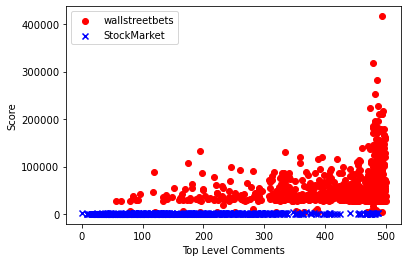

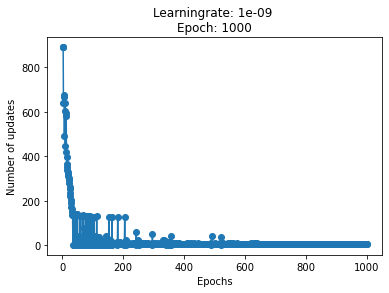

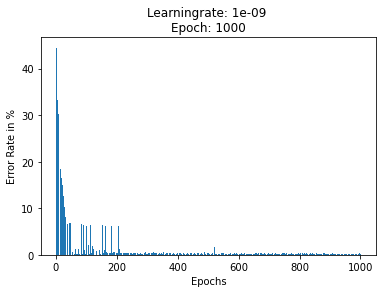

In [42]:
RC.makeClassifier(eta=0.000000001, n_iter=1000)
RC.makeTestset("class", xindices=[6,4])
RC.fit(RC.X,RC.y)
RC.epochPlot()
RC.epochProbPlot()

Although the observations should be relatively easy to separate, we see that the perceptron algorithm converges to 0 at epochs of about 650. 

Although there are still smaller error rates, the algorithm manages to separate the data well at $\eta = 0.000000001$.

<br><br><br>
**Next:** Trying some smaller learning rate in order to see whats happening.<br>
Same parameters with $\eta=0.0001$

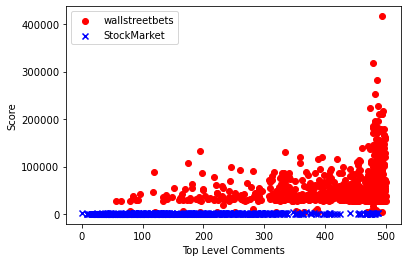

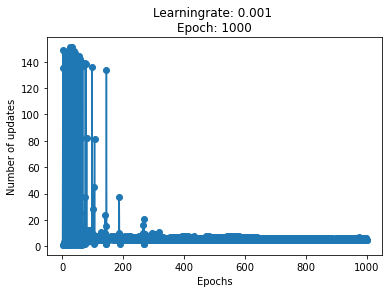

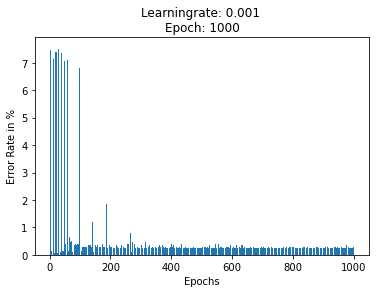

In [45]:
RC.makeClassifier(eta=0.001, n_iter=1000)
RC.makeTestset("class", xindices=[6,4])
RC.fit(RC.X,RC.y)
RC.epochPlot()
RC.epochProbPlot()

We can see that the smaller $\eta$ leads to higher error rates at the beginning of our algorithmus. This is exactly what we expect if the learning rate grows.

Nevertheless the error rate converges earlier near to zero than in the previous example!

---

**Example Nr. 2**<br>
Here we will use features that are unlikely to perfectly predict the subreddit. Therefore we will use the average number of sentences per comment and the percentage (decimal) of submissions mentioned GameStop in the comment area as our new features.

parameters:<br>
$n$ = 1, 859<br>
$\eta$ = 0.00001<br>
Epoch = 1000

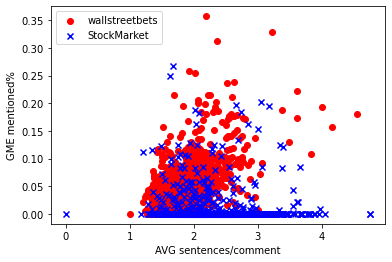

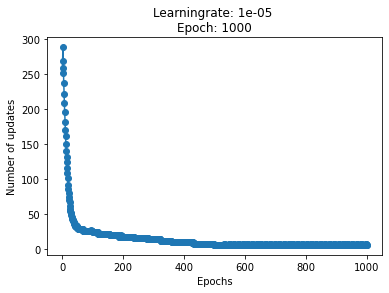

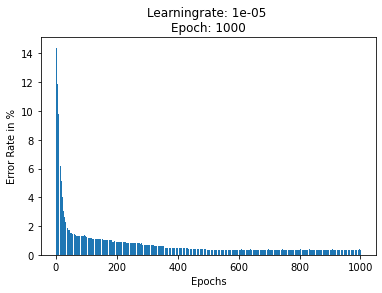

In [46]:
RC.makeClassifier(eta=0.00001, n_iter=1000)
RC.makeTestset("class",xindices=[9,10])
RC.fit(RC.X,RC.y)
RC.epochPlot()
RC.epochProbPlot()

We can see that the Perceptron class still does a good job in predicting the subreddit. Even if the error rate is not at 0%, there are only a few subreddits which are not correctly classified after 1,000 iterations.

Now we will change some parameters of our example 2.<br><br><br>

$\eta = 0.0000001$<br>
$Epoch = 3,000$

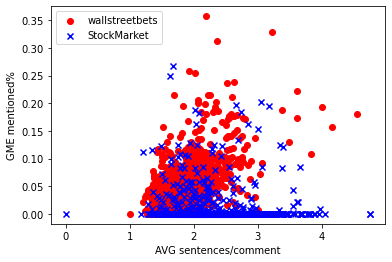

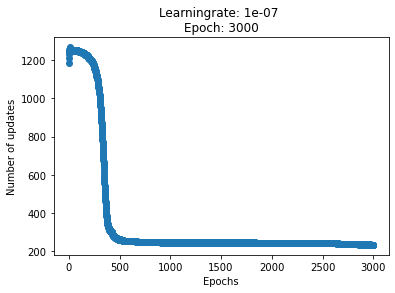

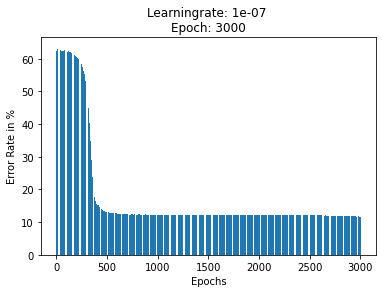

In [53]:
RC.makeClassifier(eta=0.0000001, n_iter=3000)
RC.makeTestset("class",xindices=[9,10])
RC.fit(RC.X,RC.y)
RC.epochPlot()
RC.epochProbPlot()

It can be seen that the learningrate has a significant influence on our prediction in case of this "messy" features. 

If we decrease the learningrate, the number of updates (especially the first 500 iterations) significantly increases. Therefore, if we decrease the learning rate we should increase the number of iterations at the same time to get a better prediction result! 

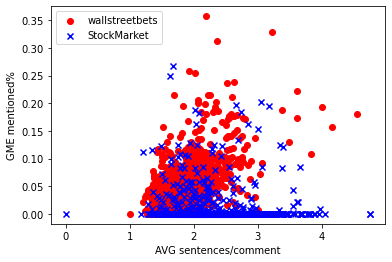

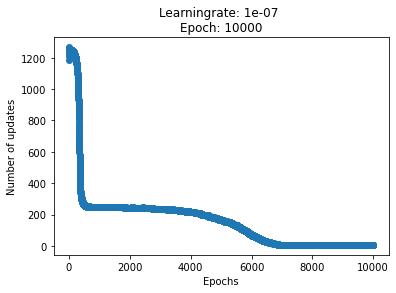

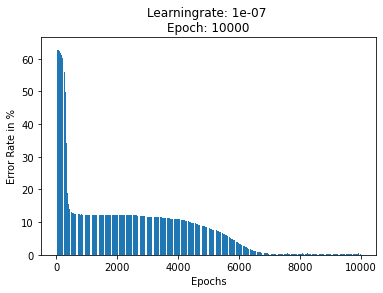

In [54]:
RC.makeClassifier(eta=0.0000001, n_iter=10000)
RC.makeTestset("class",xindices=[9,10])
RC.fit(RC.X,RC.y)
RC.epochPlot()
RC.epochProbPlot()

Thats exaclty what we expected! The fewer $\eta$, the higher must be the number of iterations!<br><br>

**With $\eta = 0.0000001$ and 10,000 iterations we received error rates near 0%**

---

# **Alternative approach: Discriminant Analysis**  
**Out of scope from this homework task!**

**Why did we do LDA?** We wondered why the error rate is not at 0%, even if we had this well separated observations in our model. So we wanted to check if there is any mistake in our preprocessing or the scrapped data. For this purposes we tried to classify the subreddits with a slightly more advanced classification method.


**LDA approach**: The apprach is to model the distribution of X in each of the classes separately, and then use *Bayes theorem* to flip things around and obtain $Pr(Y|X)$. <br><br>

$Pr(Y=k|X=x) = \frac{\pi_k f_k(x)}{\sum_{l = 1}^{K} \pi_l f_l (x)}$, where <br><br>

$f_k(x) = Pr(X = x|Y=k)$ is the density for X in class *k*. We use normal densities for these, separately in each class.<br>
$\pi_k = Pr(Y=k)$ is the marginal or prior probability for class *k*!

\* *source: Hastie T./Tibshirani R. (2013): An Introduction to Statistical Learning (Chapter 4: Classification, S. 138 ff.)*

<br>
For the purposes of this alternative approach we used the LinearDiscriminantAnalysis from the `sklearn` library!

In [55]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(RC.X, RC.y)

print(clf.score(RC.X, RC.y))

0.863905325443787


It can be seen that the problem does also occur, when we change our classifier from Perceptron to LDA. LDA classifies the subreddit with an accuracy of 86%. Therefore we guess, that the (high) missclassification rates, especially at low epochs, are not resulting from the perceptron algorithm and **does not result from our code**! 